<a href="https://colab.research.google.com/github/spdsp04/Automatic_Ticket_Classification/blob/main/Automatic_Ticket_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Ticket Classification

### By: Durgesh Chaubey

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [1]:
# Setting up Google Colab for usage. Please disable if running locally.
import pathlib
import os
from google.colab import drive
drive.mount('/content/drive')
#base_dir = pathlib.Path('/content/drive/MyDrive/Automatic_Ticket_Classification')
#os.chdir(str(base_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the necessary libraries

In [2]:
! pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## 1. Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Automatic_Ticket_Classification/complaintssc.json')

# returns JSON object as a dictionary 
data = json.load(f)
f.close()
df=pd.json_normalize(data)

### Data preparation

In [5]:
# Inspect the dataframe to understand the given data.

In [6]:
# Checking shape of dataframe
df.shape

(78313, 22)

In [7]:
# Making all columns of the dataframe visible.
pd.set_option('display.max_columns', None)

In [8]:
# Basic check of what the data looks like
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
# Inspecting column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [10]:
#print the column names
cols = df.columns.to_list()
print("Columns names:\n",cols)

Columns names:
 ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [11]:
# Checking null value counts for each column.
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

Columns which begin with "_source._" can be problematic in python/pandas. Hence, we should remove the prefixes to avoid any issues in the future.
Also removing the underscore at the beginning of column names.

In [12]:
#Assign new column names
cols_new = [re.sub('source.','',col[1:]) for col in cols]
print("New column names:\n",cols_new, "\n")

# Applying new column names
df.columns = cols_new
df.head()

New column names:
 ['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'] 



,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


#### Initial insights
- Our primary column of interest is "complaint_what_happened". There seem to be some blanks in this column as well, which would render these rows useless for our use.
- These rows may be deleted.
- The column names have been updated to avoid any issues with existing dots (.) in the column names.
- Several of the other columns can be dropped, which shall be done in time.

In [13]:
# Checking no. of null values in "complaints_what_happened" column.
df.complaint_what_happened.isnull().sum()

0

In [14]:
# Number of rows with blank complaints
print("No. of rows with blank complaints: ",len(df[(df.complaint_what_happened == "") | (df.complaint_what_happened == " ")]))

No. of rows with blank complaints:  57241


In [15]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r"^\s*$",np.NaN,regex=True)
print("No. of rows with nan in complaints column: ", df.complaint_what_happened.isnull().sum())

No. of rows with nan in complaints column:  57241


In [16]:
# Number of rows with blank complaints after replacing with NaN
print("No. of rows with blank complaints: ",len(df[(df.complaint_what_happened == "") | (df.complaint_what_happened == " ")]))

No. of rows with blank complaints:  0


In [17]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

print("New shape of dataframe: ")
df.shape

New shape of dataframe: 


(21072, 22)

In [18]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## 2. Text pre-processing
## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [19]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_preprocess(text):
    # Text to lower case
    text1 = text.lower()
    
    # Removing any leading and trailing spaces
    text2 = text1.strip()
    
    # Removing text within square brackets
    text3 = re.sub(r"[\[].*?[\]]","",text2).strip()
    
    # Removing punctuations
    text4 = re.sub(r"[^\w\s]","",text3).strip()
    
    # Removing words containing numbers
    text5 = re.sub("\S*\d\S*","",text4).strip()   
    
    return text5

In [20]:
df['complaints_cleaned'] = df.complaint_what_happened.apply(text_preprocess)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints_cleaned
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...


In [21]:
# Importing libraries for text processing steps.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
df_clean = df.complaints_cleaned.to_frame()
df_clean.columns = ["complaints"]
df_clean.head()

,complaints
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [23]:
# Importing "swifter" to speed up lemmatization using mutithread processing.

!pip install swifter
import swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [25]:
#Write your function to Lemmatize the texts

stopwords = stopwords.words('english')
wordnet_lem = WordNetLemmatizer()

def lemmatizer(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords]
    proc_token = []
    # Using nltk pos tagger which may not capture the context like Spacy's POS tagger. However, it should be good enough for use here.
    for word,pos in pos_tag(tokens):
        try:
            proc_token.append(wordnet_lem.lemmatize(word,pos = pos[0].lower()))
        except:
            proc_token.append(wordnet_lem.lemmatize(word))
    lemmatized_text = ' '.join(proc_token)
    return lemmatized_text

In [26]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint_what_happened","complaints_cleaned"]]
#df_clean.columns = ["raw_complaints","cleaned_complaints"]

# Apply lemmatization and store the output in a separate column
df_clean["lemmatized_complaints"] = df_clean["complaints_cleaned"].swifter.apply(lemmatizer)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


#### It is more likely the words of interest for Topic Modelling are nouns and proper nouns. Words with other POS tags are unlikely to be of much use to us. Hence, the code below creates a new column which includes only words with POS tags as nouns.

In [28]:
#Write your function to extract the POS tags (Using Spacy)

nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm

pos_tags = []  # List to store POS tags of each lemmatized complaint
nouns = []     # List to store only the nouns from the complaint

for complaint in tqdm(df_clean.lemmatized_complaints):
    pos = ''
    noun = ''
    proc_complaint = nlp(complaint)
    for tok in proc_complaint:
        pos += tok.pos_ + ' '
        if tok.pos_ in str(('NOUN', 'PROPN')) :
            noun += (tok.lemma_.lower()) + ' '
    pos_tags.append(pos.strip())
    nouns.append(noun.strip())

100%|██████████| 21072/21072 [10:44<00:00, 32.71it/s]


In [29]:
df_clean['pos_tags_lemmatized'] = pd.Series(pos_tags, index=df_clean.index)
df_clean['complaints_nouns_only'] = pd.Series(nouns, index=df_clean.index)

#Reassigning index of cleaned dataframe
df_clean.reset_index(drop=True, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
#The clean dataframe should now contain the raw complaint, cleaned_complaints, lemmatized complaints with respective POS tags, 
#and the complaints after removing words with non-noun (NOUN, PROPN) POS tags.
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB N...,morning name xxxx xxxx stop chase bank cardmem...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,VERB PROPN PROPN PROPN VERB NOUN NOUN NOUN NOU...,xxxx xxxx card agent upgrade anniversary date ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,NOUN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,VERB NOUN PROPN PROPN NOUN VERB ADP NOUN VERB ...,book xxxx xxxx ticket offer ticket apply rewar...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN PROPN PROP...,grand son check deposit chase account fund cle...


## 3.Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [31]:
df_clean.complaint_what_happened.str.len().sort_values(ascending=False)

436      31611
11241    31385
14251    29948
2308     29239
1130     25757
         ...  
16450       21
8825        21
1619        20
5799        19
8697        19
Name: complaint_what_happened, Length: 21072, dtype: int64

Text(0.5, 0, 'Character length ranges')

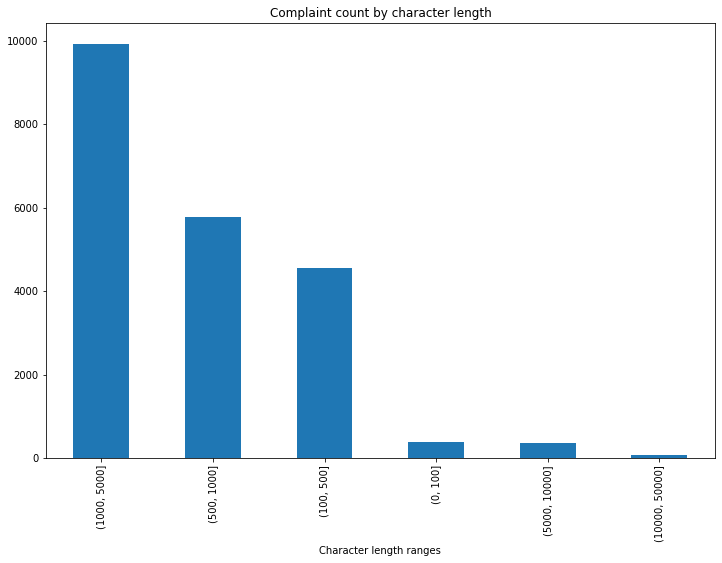

In [32]:
# Write your code here to visualise the data according to the 'Complaint' character length
bins = [0, 100, 500, 1000, 5000, 10000, 50000]
temp_df = df_clean.complaint_what_happened.str.len().to_frame()
temp_df.columns = ["length"]
temp_df['binned'] = pd.cut(temp_df['length'], bins)
temp_df.binned.value_counts()

plt.figure(figsize=(12,8))
temp_df.binned.value_counts().plot(kind="bar")
plt.title("Complaint count by character length")
plt.xlabel("Character length ranges")

#### Find the top 40 words by frequency among all the articles after processing the text.

Text(0.5, 1.0, 'Most frequent words in complaints after processing')

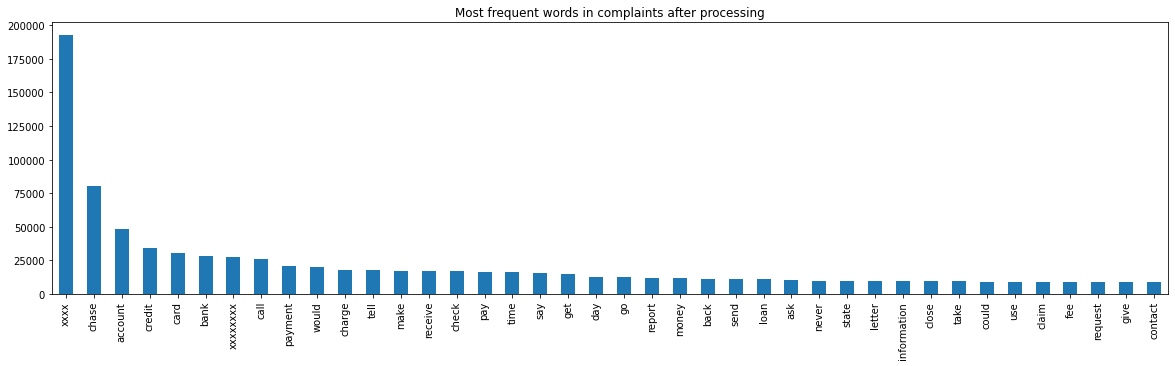

In [33]:
# Most frequent words in the processed (lemmatized) complaints
most_freq_lem=[] # List to extract most frequent words

for complaint in df_clean.lemmatized_complaints:
    for word in complaint.split(' '):
        most_freq_lem.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_lem)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent words in complaints after processing")

In [34]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


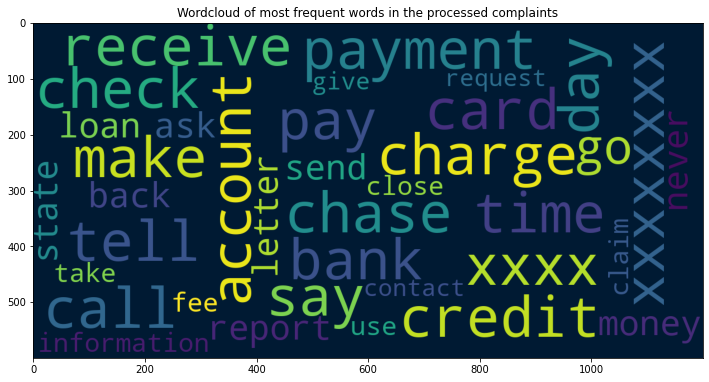

In [35]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = '#001a33', width = 1200, height = 600, colormap = 'viridis', max_words = 50, contour_width = 3, max_font_size = 100, contour_color = 'steelblue', random_state = 0)

most_freq_words = pd.DataFrame(most_freq_lem)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_words]))

plt.imshow(wordcloud)
plt.title("Wordcloud of most frequent words in the processed complaints")
plt.show()

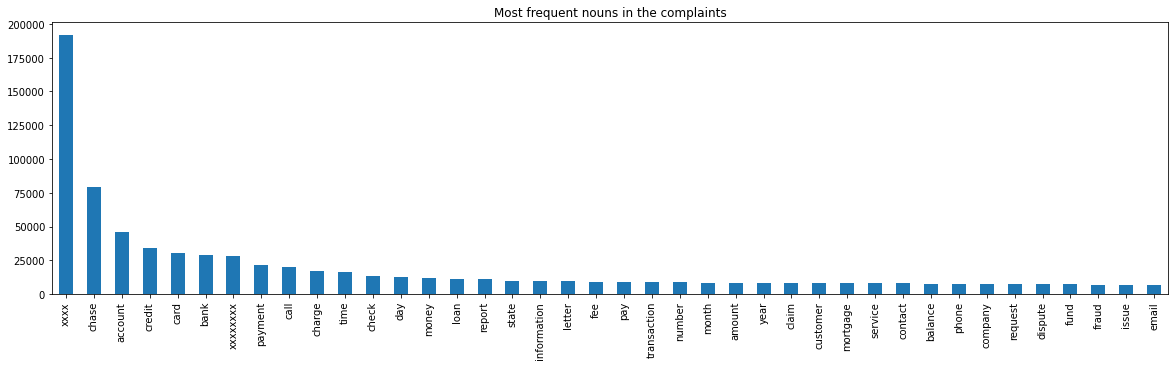

In [36]:
# Most frequent nouns in the processed complaints
most_freq_nouns=[] # List to extract most frequent nouns

for complaint in df_clean.complaints_nouns_only:
    for word in complaint.split(' '):
        most_freq_nouns.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_nouns)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent nouns in the complaints")
plt.show()

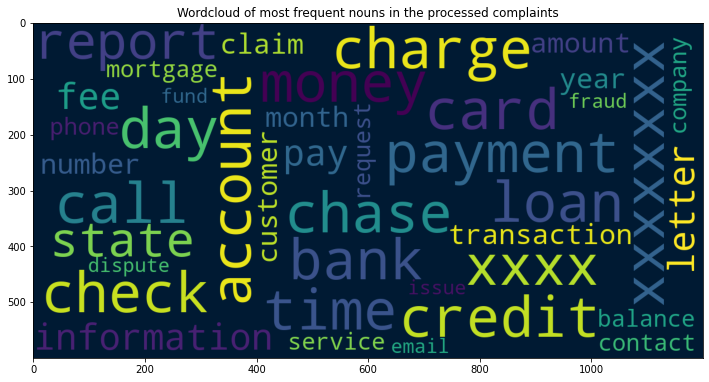

In [37]:
#Using a word cloud find the top 40 nouns by frequency among all the articles after processing the text

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = '#001a33', width = 1200, height = 600, colormap = 'viridis', max_words = 50, contour_width = 3, max_font_size = 100, contour_color = 'steelblue', random_state = 0)

most_freq_noun_words = pd.DataFrame(most_freq_nouns)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_noun_words]))

plt.imshow(wordcloud)
plt.title("Wordcloud of most frequent nouns in the processed complaints")
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [38]:
# Importing required libraries.
from nltk.util import ngrams 
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

In [39]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word') 
word_vect = vectorizer.fit_transform(df_clean['complaints_nouns_only']) 
freqs = sum(word_vect).toarray()[0]

unigram_df = pd.DataFrame(freqs, index=vectorizer.get_feature_names(), columns=['frequency']) 

In [40]:
#Print the top 30 words in the unigram by frequency
print("Top 30 words in the unigram by frequency:")
unigram_df.sort_values(by="frequency", ascending = False).head(30)

Top 30 words in the unigram by frequency:


,frequency
xxxx,191636
chase,79562
account,45915
credit,33992
card,30437
bank,28586
xxxxxxxx,27896
payment,21158
call,19797
charge,16793


<Figure size 1440x360 with 0 Axes>

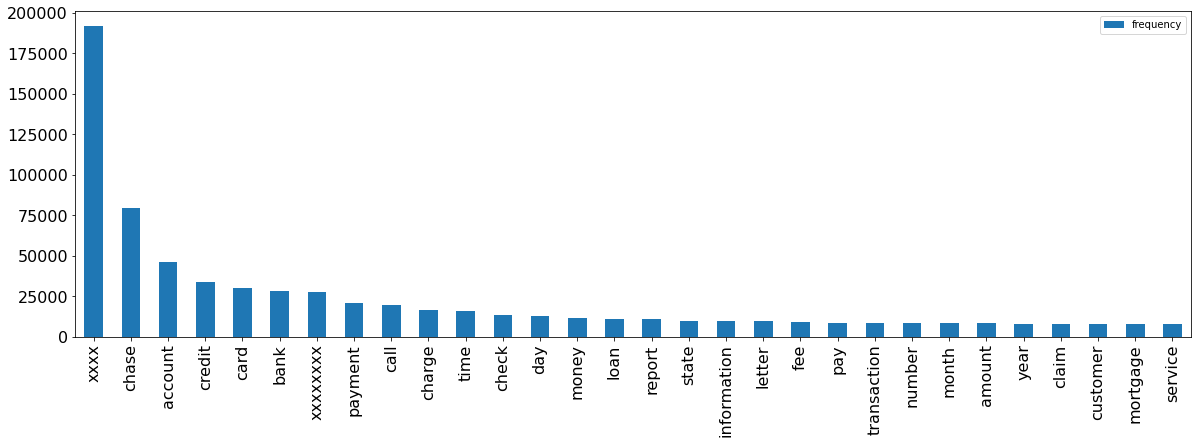

In [41]:
plt.figure(figsize=(20, 5))
unigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

In [42]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), analyzer='word') 
word_vector_bigram = vectorizer_bigram.fit_transform(df_clean['complaints_nouns_only']) 
freqs_bigram = sum(word_vector_bigram).toarray()[0]

bigram_df = pd.DataFrame(freqs_bigram, index=vectorizer_bigram.get_feature_names(), columns=['frequency'])

Top 30 bigrams by frequency:
                   frequency
xxxx xxxx              87217
chase bank             12845
credit card            12834
xxxx chase              5314
call chase              4570
credit report           3990
chase xxxx              3971
xxxxxxxx xxxx           3731
check account           3431
chase credit            3367
account xxxx            3341
account chase           3169
xxxx xxxxxxxx           3131
customer service        3077
jp morgan               2865
xxxx account            2782
xxxxxxxx xxxxxxxx       2574
xxxx credit             2534
morgan chase            2475
bank account            2448
chase account           2325
bank xxxx               2139
call xxxx               1989
debit card              1957
number xxxx             1951
contact chase           1947
xxxx payment            1866
card xxxx               1856
credit score            1714
payment xxxx            1708


<Figure size 1440x360 with 0 Axes>

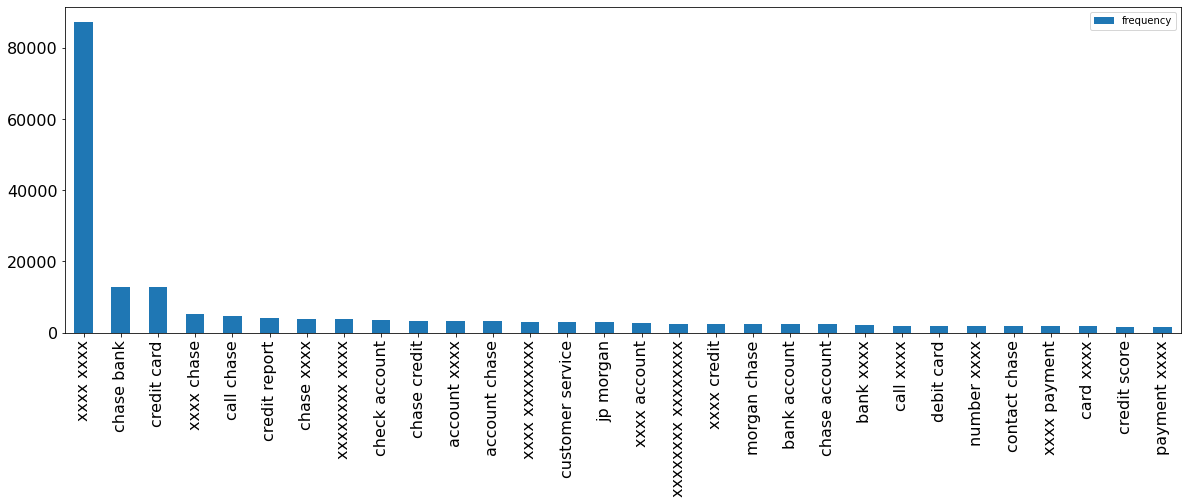

In [43]:
#Print thelemmatized_complaints 10 words in the bigram frequency
print("Top 30 bigrams by frequency:")
print(bigram_df.sort_values(by="frequency", ascending = False).head(30))

plt.figure(figsize=(20, 5))
bigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

In [44]:
Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_trigram = CountVectorizer(ngram_range=(3,3), analyzer='word') 
word_vector_trigram = vectorizer_trigram.fit_transform(df_clean['complaints_nouns_only']) 
freqs_trigram = sum(word_vector_trigram).toarray()[0]

trigram_df = pd.DataFrame(freqs_trigram, index=vectorizer_trigram.get_feature_names(), columns=['frequency'])

In [45]:
Print the top 30 words in the trigram frequency
print("Top 30 trigrams by frequency:")
print(trigram_df.sort_values(by="frequency", ascending = False).head(30))

plt.figure(figsize=(20, 5))
trigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

#### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [46]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB N...,morning name xxxx xxxx stop chase bank cardmem...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,VERB PROPN PROPN PROPN VERB NOUN NOUN NOUN NOU...,xxxx xxxx card agent upgrade anniversary date ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,NOUN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,VERB NOUN PROPN PROPN NOUN VERB ADP NOUN VERB ...,book xxxx xxxx ticket offer ticket apply rewar...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN PROPN PROP...,grand son check deposit chase account fund cle...


In [47]:
# Removing masked customer names and other masked data signified by 'xxxx', since they are of no use to us.
df_clean['complaints_cleaned'] = df_clean['complaints_cleaned'].str.replace('xxxx','')
df_clean['lemmatized_complaints'] = df_clean['lemmatized_complaints'].str.replace('xxxx','')
df_clean['complaints_nouns_only'] = df_clean['complaints_nouns_only'].str.replace('xxxx','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [48]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...,good morning name appreciate could help put ...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB N...,morning name stop chase bank cardmember serv...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...,upgraded card tell agent upgrade anniversary...,VERB PROPN PROPN PROPN VERB NOUN NOUN NOUN NOU...,card agent upgrade anniversary date agent in...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,NOUN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came a...,try book ticket come across offer apply towa...,VERB NOUN PROPN PROPN NOUN VERB ADP NOUN VERB ...,book ticket offer ticket apply reward card i...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN PROPN PROP...,grand son check deposit chase account fund cle...


## 4.Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [49]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.9,
    max_features=5000, # Keeping max_features to 5000 to keep within memory limits.
    ngram_range=(1, 3)
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [50]:
#Write your code here to create the Document Term Matrix (tfidf) by transforming the complaints column present in df_clean.

tfidf = tfidf_vectorizer.fit_transform(df_clean['complaints_nouns_only'])
features = tfidf_vectorizer.get_feature_names()

# Creating a dataframe to display the document-term matrix created above
tfidf_df = pd.DataFrame(tfidf.toarray(), columns = features)
tfidf_df.head()

aarp  ability  abuse  acceptance  access  access account  access bank  \
0   0.0      0.0    0.0         0.0     0.0             0.0          0.0   
1   0.0      0.0    0.0         0.0     0.0             0.0          0.0   
2   0.0      0.0    0.0         0.0     0.0             0.0          0.0   
3   0.0      0.0    0.0         0.0     0.0             0.0          0.0   
4   0.0      0.0    0.0         0.0     0.0             0.0          0.0   

   access chase  access credit  access fund  access information  access money  \
0           0.0            0.0          0.0                 0.0           0.0   
1           0.0            0.0          0.0                 0.0           0.0   
2           0.0            0.0          0.0                 0.0           0.0   
3           0.0            0.0          0.0                 0.0           0.0   
4           0.0            0.0          0.0                 0.0           0.0   

   accident  accommodation  accord  accord chase  accordance   account  \
0       0.0            0.0     0.0           0.0         0.0  0.055768   
1       0.0            0.0     0.0           0.0         0.0  0.061493   
2       0.0            0.0     0.0           0.0         0.0  0.000000   
3       0.0            0.0     0.0           0.0         0.0  0.094216   
4       0.0            0.0     0.0           0.0         0.0  0.087166   

   account access  account account  account account account  \
0             0.0              0.0                      0.0   
1             0.0              0.0                      0.0   
2             0.0              0.0                      0.0   
3             0.0              0.0                      0.0   
4             0.0              0.0                      0.0   

   account account balance  account account chase  account account number  \
0                      0.0                    0.0                     0.0   
1                      0.0                    0.0                     0.0   
2                      0.0                    0.0                     0.0   
3                      0.0                    0.0                     0.0   
4                      0.0                    0.0                     0.0   

   account activity  account address  account agreement  account amount  \
0               0.0              0.0                0.0             0.0   
1               0.0              0.0                0.0             0.0   
2               0.0              0.0                0.0             0.0   
3               0.0              0.0                0.0             0.0   
4               0.0              0.0                0.0             0.0   

   account ask  account atm  account attempt  account authorization  \
0     0.000000          0.0              0.0                    0.0   
1     0.000000          0.0              0.0                    0.0   
2     0.000000          0.0              0.0                    0.0   
3     0.125338          0.0              0.0                    0.0   
4     0.000000          0.0              0.0                    0.0   

   account balance  account balance account  account bank  \
0              0.0                      0.0           0.0   
1              0.0                      0.0           0.0   
2              0.0                      0.0           0.0   
3              0.0                      0.0           0.0   
4              0.0                      0.0           0.0   

   account bank account  account banker  account base  account bill  \
0                   0.0             0.0           0.0           0.0   
1                   0.0             0.0           0.0           0.0   
2                   0.0             0.0           0.0           0.0   
3                   0.0             0.0           0.0           0.0   
4                   0.0             0.0           0.0           0.0   

   account block  account bonus  account branch  account business  \
0            0.0            0.0

In [51]:
tfidf_df.shape

(21072, 5000)

In [52]:
len(tfidf_vectorizer.get_feature_names())

5000

## 5.Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [53]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

### Starting with 15 topics as a test

In [54]:
#Load your nmf_model with the n_components 

#Initial test with num_topics = 15
num_topics = 15 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [55]:
W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

In [56]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,account chase,chase account,account account,chase,check account,bank account,access,transfer,reason,balance,money,branch,business,card account
Topic 2,card,credit,credit card,chase credit,chase credit card,chase,card chase,chase card,score,limit,credit card chase,card account,card credit,credit score,use
Topic 3,mortgage,home,property,chase,modification,chase mortgage,foreclosure,year,house,sale,escrow,mortgage payment,tax,insurance,bankruptcy
Topic 4,inquiry,inquiry credit,inquiry credit report,credit report,credit,jpmcb,credit inquiry,card inquiry,jpmcb card,report inquiry,inquiry inquiry,inquiry chase,report,application,credit report inquiry
Topic 5,payment,payment payment,month,payment chase,pay,chase payment,amount,chase,day,payment credit,payment month,time,account payment,auto,payment account
Topic 6,charge,dispute,merchant,dispute charge,company,charge chase,chase,refund,charge account,purchase,amount,charge charge,chase charge,item,charge credit
Topic 7,fee,overdraft,overdraft fee,charge,charge fee,fee charge,transaction,charge overdraft,charge overdraft fee,fee account,pay,fee chase,fee fee,time,year
Topic 8,morgan,jp,jp morgan,morgan chase,jp morgan chase,morgan chase bank,chase,account jp,account jp morgan,complaint,morgan chase credit,bank jp,call jp morgan,call jp,morgan chase account
Topic 9,bank,chase bank,chase,bank account,money,bank chase,chase bank account,account chase bank,bank credit,bank bank,bank chase bank,call chase bank,wire,complaint,chase bank credit
Topic 10,call,chase,phone,number,letter,email,information,time,customer,service,state,day,request,call chase,contact


- There are perhaps too many topics and it is difficult to identify patterns / coherence within each topic.
- It may be better to try smaller number of topics.

### Trying the same as above, but with 10 topics

In [57]:
#Load your nmf_model with the n_components 

# Trying 10 topics
num_topics = 10 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,call,chase,claim,number,phone,transaction,email,information,day,time,fraud,letter,state,customer,contact
Topic 2,card,credit,credit card,chase,chase credit,chase credit card,card chase,chase card,score,card account,account,limit,balance,year,credit card chase
Topic 3,loan,mortgage,modification,home,chase,property,year,rate,foreclosure,loan modification,house,sale,refinance,document,chase mortgage
Topic 4,report,inquiry,credit,credit report,inquiry credit,inquiry credit report,bureau,report credit,credit bureau,jpmcb,debt,information,company,reporting,identity
Topic 5,payment,payment payment,month,pay,balance,payment chase,chase,statement,chase payment,interest,amount,auto,time,day,payment credit
Topic 6,charge,dispute,merchant,dispute charge,chase,company,charge chase,purchase,amount,charge account,refund,charge charge,fraud,chase charge,item
Topic 7,fee,overdraft,balance,charge,overdraft fee,interest,charge fee,transaction,pay,fee charge,transfer,charge overdraft,rate,fee account,charge overdraft fee
Topic 8,morgan,jp,jp morgan,morgan chase,jp morgan chase,morgan chase bank,chase,complaint,account jp,account jp morgan,morgan chase credit,foreclosure,bank jp,morgan chase account,call jp morgan
Topic 9,bank,chase bank,chase,money,bank account,bank chase,chase bank account,account chase bank,bank bank,cash,bank chase bank,bank credit,wire,call chase bank,bank money
Topic 10,account,check,deposit,fund,check account,money,chase,account chase,branch,account account,chase account,day,business,reason,access


- There still isn't a lot of coherence within the topics.
- Decreasing no. of topics further.

### Using 5 topics

In [58]:
#Load your nmf_model with the n_components 

# Trying 5 topics
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,chase,money,deposit,chase bank,fund,call,transaction,branch,day,check account,claim,account chase
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,call,chase credit card,merchant,service,company,time,fraud
Topic 3,loan,mortgage,chase,home,modification,property,morgan,jp,jp morgan,foreclosure,document,year,letter,morgan chase,jp morgan chase
Topic 4,credit,report,inquiry,credit report,inquiry credit,inquiry credit report,account,bureau,report credit,credit bureau,score,debt,jpmcb,information,credit score
Topic 5,payment,balance,fee,interest,month,pay,payment payment,statement,payment chase,amount,chase,chase payment,bill,time,account


- This seems to capture coherence within topics.
- Let's proceed with 5 topics

In [59]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping_num = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}

In [60]:
W = pd.DataFrame(W, columns=[f'Topic {i+1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping_num.get(x.idxmax()) if x.idxmax() in topic_mapping_num.keys() else '4', axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.023344,0.004542,0.020216,0.012970,0.004169,0
1,0.005729,0.014072,0.005408,0.002001,0.001140,1
2,0.000000,0.023711,0.001889,0.044508,0.000000,3
3,0.018915,0.019491,0.015315,0.061673,0.000000,3
4,0.064238,0.000000,0.002507,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.103676,0.000000,3
6,0.052419,0.002800,0.009581,0.000000,0.009993,0
7,0.002793,0.006413,0.043177,0.000000,0.052788,4
8,0.040718,0.026538,0.020833,0.003494,0.002104,0
9,0.000000,0.044683,0.000000,0.068950,0.000000,3


In [61]:
# Checking the frequency of each identified topic
W['max_topic'].value_counts()

1    6188
0    5990
2    3864
3    2534
4    2496
Name: max_topic, dtype: int64

In [62]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] =W['max_topic'].apply(lambda x:int(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
df_clean.tail()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only,Topic
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,NOUN NOUN NOUN NOUN NOUN VERB ADJ NOUN VERB AD...,chase card customer well decade solicitation c...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit c...,wednesday call chas visa credit card provid...,PROPN PROPN PROPN PROPN PROPN PROPN PROPN NOUN...,wednesday call chas visa credit card provid...,1
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not unders...,familiar pay understand great risk provide co...,ADJ PROPN NOUN VERB ADJ NOUN VERB NOUN VERB AD...,pay risk consumer chase bank app chase year t...,0
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,ADJ NOUN NOUN PRON VERB NOUN NOUN NOUN NOUN NO...,credit yrs chase credit card chase freedom pr...,4
21071,Roughly 10+ years ago I closed out my accounts...,roughly years ago i closed out my accounts wi...,roughly year ago close account jp morgan chase...,ADV NOUN ADV ADJ NOUN PROPN PROPN PROPN PROPN ...,year account jp morgan chase bank order line ...,4


In [64]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   complaints_cleaned       21072 non-null  object
 2   lemmatized_complaints    21072 non-null  object
 3   pos_tags_lemmatized      21072 non-null  object
 4   complaints_nouns_only    21072 non-null  object
 5   Topic                    21072 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 987.9+ KB


In [65]:
#Print the first 5 Complaint for each of the Topics
df_clean_sample = df_clean.groupby('Topic').head(5)

#df_clean_sample.sort_values('Topic')
df_clean_sample.sort_values(by='Topic')

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...,good morning name appreciate could help put ...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB N...,morning name stop chase bank cardmember serv...,0
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN PROPN PROP...,grand son check deposit chase account fund cle...,0
10,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and,mishandle account chase auto,PROPN NOUN NOUN NOUN PROPN,mishandle account chase auto,0
6,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,PROPN PROPN PROPN PROPN VERB NOUN NOUN NOUN PR...,notice jp morgan chase account debit card tues...,0
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on i made a payment to an online retailer u...,make payment online retailer use chase quick ...,PROPN VERB NOUN ADJ NOUN VERB NOUN ADJ NOUN PR...,payment retailer chase pay chase website sca...,0
21,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,i am a senior citizen that has been scammed by...,senior citizen scammed several company pay t...,ADJ NOUN VERB ADJ NOUN PROPN PROPN VERB NOUN N...,citizen company time share company refund cr...,1
19,I made a purchase with XXXX XXXX XXXX on XX/XX...,i made a purchase with on in the amount of...,make purchase amount charge twice transacti...,VERB NOUN PROPN PROPN PROPN PROPN NOUN ADJ NOU...,purchase amount charge transaction place di...,1
16,"XXXX XXXX a sofa, love seat, table and chairs ...",a sofa love seat table and chairs and was ne...,sofa love seat table chair never deliver deb...,PROPN PROPN PROPN NOUN NOUN NOUN NOUN ADV VERB...,sofa love seat table chair debit card charge...,1
14,My chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,chase amazon card decline cater order place br...,PROPN NOUN NOUN NOUN NOUN NOUN PROPN NOUN NOUN...,chase amazon card decline cater order place br...,1
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...,upgraded card tell agent upgrade anniversary...,VERB PROPN PROPN PROPN VERB NOUN NOUN NOUN NOU...,card agent upgrade anniversary date agent in...,1


In [66]:
# Checking whether each complaint has an assigned topic or not; and whether the count for each topic matches that from our Document-Topic matrix
df_clean.Topic.value_counts()

1    6188
0    5990
2    3864
3    2534
4    2496
Name: Topic, dtype: int64

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Mortgage/Loan
* Theft/Dispute Reporting
* Others

In [67]:
#Create the dictionary of Topic names and Topics

Topic_names =   {
                0 : "Bank account services",
                1 : "Credit Card/Prepaid Card",
                2 : "Mortgages/loans",
                3 : "Theft/Dispute reporting",
                4 : "Others"
                }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
df_clean.Topic.value_counts()

Credit Card/Prepaid Card    6188
Bank account services       5990
Mortgages/loans             3864
Theft/Dispute reporting     2534
Others                      2496
Name: Topic, dtype: int64

## 6.Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [69]:
#Create the dictionary again of Topic names and Topics

topic_labels = {
    "Bank account services" : 0,
    "Credit Card/Prepaid Card" : 1,
    "Mortgages/loans" : 2,
    "Theft/Dispute reporting" : 3,
    "Others" : 4
}
#Replace Topics with Topic labels
df_clean['Topic'] = df_clean['Topic'].map(topic_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
df_clean

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,pos_tags_lemmatized,complaints_nouns_only,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...,good morning name appreciate could help put ...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB N...,morning name stop chase bank cardmember serv...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...,upgraded card tell agent upgrade anniversary...,VERB PROPN PROPN PROPN VERB NOUN NOUN NOUN NOU...,card agent upgrade anniversary date agent in...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,NOUN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOUN...,chase card report application submit identity ...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came a...,try book ticket come across offer apply towa...,VERB NOUN PROPN PROPN NOUN VERB ADP NOUN VERB ...,book ticket offer ticket apply reward card i...,3
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,PROPN NOUN VERB NOUN NOUN NOUN NOUN PROPN PROP...,grand son check deposit chase account fund cle...,0
...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,NOUN NOUN NOUN NOUN NOUN VERB ADJ NOUN VERB AD...,chase card customer well decade solicitation c...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit c...,wednesday call chas visa credit card provid...,PROPN PROPN PROPN PROPN PROPN PROPN PROPN NOUN...,wednesday call chas visa credit card provid...,1
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not unders...,familiar pay understand great risk provide co...,ADJ PROPN NOUN VERB ADJ NOUN VERB NOUN VERB AD...,pay risk consumer chase bank app chase year t...,0
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,ADJ NOUN NOUN PRON VERB NOUN NOUN NOUN NOUN NO...,credit yrs chase credit card chase freedom pr...,4


In [71]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [72]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   Topic                    21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [73]:
training_data.head()

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",3
4,my grand son give me check for {$1600.00} i de...,0


In [74]:
training_data.Topic.value_counts()

1    6188
0    5990
2    3864
3    2534
4    2496
Name: Topic, dtype: int64

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [75]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = vectorizer.fit_transform(training_data.complaint_what_happened)

print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [6 0 0 ... 1 1 0]
 [2 0 0 ... 3 1 0]]


In [76]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
word_vect.shape

(21072, 883)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## Write your code here to build any 3 models and evaluate them using the required metrics

## 7.Model Training and Evaluation

### Preparing the data for training

In [77]:
# Creating a dataframe of the tf-idf vector for use in model training.
word_vect_df = pd.DataFrame(word_vect.toarray(),columns=vectorizer.get_feature_names(),index=training_data.index)
word_vect_df.head()

,00,00 account,00 chase,00 xx,00 xx xx,00 xxxx,00 xxxx xxxx,10,10 days,100,100 00,1000,1000 00,12,15,18,19,20,200,200 00,2000,2000 00,2015,2016,2017,2018,2019,2020,24,30,30 days,50,500,500 00,60,90,ability,able,absolutely,accept,accepted,access,according,account,account chase,account chase bank,account closed,account number,account xx,account xx xx,account xxxx,account xxxx xxxx,accounts,act,action,actions,activity,actually,add,added,addition,additional,address,advised,agencies,agency,agent,ago,agreed,agreement,alert,allow,allowed,amazon,amounts,annual,answer,app,apparently,appears,application,applied,apply,approval,approved,approximately,ask,asked,asking,assist,assistance,assured,atm,attached,attempt,attempted,attempts,attorney,authorization,authorize,authorized,auto,available,avoid,aware,away,bad,balance,bank,bank account,bank chase,bank xx,bank xx xx,bank xxxx,bank xxxx xxxx,banker,banking,bankruptcy,banks,based,began,beginning,behalf,believe,best,better,billing,bills,bonus,branch,branch manager,branch xxxx,bureau,bureaus,business,business days,buy,ca,called,called chase,called xxxx,called xxxx xxxx,calling,calls,came,cancel,cancelled,car,card,card account,card chase,card company,card xx,card xx xx,card xxxx,cards,care,case,cash,cause,caused,causing,cfpb,change,changed,charge,charged,charges,charging,chase,chase account,chase bank,chase bank xxxx,chase branch,chase card,chase chase,chase checking,chase closed,chase credit,chase credit card,chase customer,chase customer service,chase did,chase freedom,chase mortgage,chase representative,chase said,chase sent,chase told,chase xx,chase xx xx,chase xxxx,chase xxxx xxxx,check,check xxxx,checked,checking,checking account,checks,claim,claimed,claiming,claims,clear,cleared,clearly,close,close account,closed,closed account,closing,code,collect,collection,come,communication,companies,company,complaint,complaint chase,complaints,complete,completed,completely,concern,confirm,confirmation,confirmed,consumer,consumers,contact,contact chase,contacted,contacted chase,contacted xxxx,contacting,continue,continued,contract,conversation,copies,copy,correct,correspondence,cost,couple,course,court,cover,covid,credit,credit account,credit bureaus,credit card,credit card account,credit card chase,credit card company,credit cards,credit report,credit reporting,credit reports,credit score,credited,current,currently,customer,customer service,customers,date,date xx,date xx xx,dated,dated xx,dated xx xx,dates,day,days,days later,deal,debit,debit card,debt,decided,decision,declined,denied,department,deposit,deposited,deposits,dept,despite,details,did,did receive,didn,didnt,different,direct,directly,discovered,dispute,disputed,document,documentation,documents,does,doing,dollars,don,dont,early,email,emailed,emails,employee,employees,end,ended,ending,ending xxxx,entire,error,escrow,evidence,executive,executive office,explain,explained,explanation,extra,extremely,fact,failed,fair,false,family,far,fault,fax,federal,fee,feel,fees,file,filed,filing,final,finally,finance,financial,fine,fix,fixed,follow,followed,following,forced,foreclosure,form,forward,fraud,fraud department,fraudulent,free,freedom,friday,funds,future,gave,getting,given,giving,going,gone,good,got,government,happen,happened,hard,having,hear,heard,held,help,high,higher,history,hold,holder,holding,home,honor,hour,hours,house,husband,id,idea,identity,identity theft,illegal,im,immediately,included,including,income,incorrect,indicated,info,inform,information,informed,initial,initially,initiated,inquiries,inquiry,instead,institution,insurance,investigate,investigation,involved,issue,issued,issues,item,items,job,jp,jp morgan,jp morgan chase,jpmorgan,jpmorgan chase,just,kept,kind,knew,know,knowledge,lack,large,late,late fees,late payment,later,law,leave,left,legal,lender,let,let know,letter,letter chase,letters,life,like,limit,line,listed,little,live,loan,loan modification,loan xxxx,loans,local,located,location,long,longer,look,looked,looking,loss,lost,

In [78]:
word_vect_df.shape

(21072, 883)

- Hence, there are 883 features that are being used for our training.

In [79]:
# Displaying feature names
features = vectorizer.get_feature_names()
print(features)

['00', '00 account', '00 chase', '00 xx', '00 xx xx', '00 xxxx', '00 xxxx xxxx', '10', '10 days', '100', '100 00', '1000', '1000 00', '12', '15', '18', '19', '20', '200', '200 00', '2000', '2000 00', '2015', '2016', '2017', '2018', '2019', '2020', '24', '30', '30 days', '50', '500', '500 00', '60', '90', 'ability', 'able', 'absolutely', 'accept', 'accepted', 'access', 'according', 'account', 'account chase', 'account chase bank', 'account closed', 'account number', 'account xx', 'account xx xx', 'account xxxx', 'account xxxx xxxx', 'accounts', 'act', 'action', 'actions', 'activity', 'actually', 'add', 'added', 'addition', 'additional', 'address', 'advised', 'agencies', 'agency', 'agent', 'ago', 'agreed', 'agreement', 'alert', 'allow', 'allowed', 'amazon', 'amounts', 'annual', 'answer', 'app', 'apparently', 'appears', 'application', 'applied', 'apply', 'approval', 'approved', 'approximately', 'ask', 'asked', 'asking', 'assist', 'assistance', 'assured', 'atm', 'attached', 'attempt', 'att

In [80]:
# Assigning our target variable to the word vector dataframe
word_vect_df["Topic"] = training_data["Topic"]

### Train-test split

In [81]:
from sklearn.model_selection import train_test_split

X= word_vect_df.drop(['Topic'], axis=1)
y= word_vect_df['Topic']

In [82]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=40, stratify=y)

#### Choosing "accuracy" as our metric of evaluation, since this is a multi-class problem, Other metrics like precision, recall, etc. are more appropriate for 

In [83]:
# Defining a function to evaluate the models
from sklearn import metrics

def evaluate_model(y_actual,y_pred):
       
    # Confusion matrix
    confusion = metrics.confusion_matrix(y_actual, y_pred)

    # Metrics calculation
    accuracy = metrics.accuracy_score(y_actual,y_pred)
    clf_report = metrics.classification_report(y_actual,y_pred)   # Sklearn classification report
    
    print("Accuracy   : " + str(accuracy))
    print("\nConfusion matrix:\n", confusion)
    print("\nClassificationReport:")
    print(clf_report)
    
    return accuracy

### Logistic Regression

In [84]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

y_train_pred=logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [85]:
lr_train_accuracy = evaluate_model(y_train.values,y_train_pred)

Accuracy   : 0.9639331814730449

Confusion matrix:
 [[4386   61   29    8    8]
 [  49 4538   18   20   16]
 [  43   35 2796   12   12]
 [  26   48   20 1796   11]
 [  45   51   47   11 1718]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4492
           1       0.96      0.98      0.97      4641
           2       0.96      0.96      0.96      2898
           3       0.97      0.94      0.96      1901
           4       0.97      0.92      0.94      1872

    accuracy                           0.96     15804
   macro avg       0.97      0.96      0.96     15804
weighted avg       0.96      0.96      0.96     15804



In [86]:
lr_test_acc = evaluate_model(y_test.values,y_pred)

Accuracy   : 0.9402050113895216

Confusion matrix:
 [[1442   28   18    4    6]
 [  22 1497    7   14    7]
 [  31   29  891    5   10]
 [  11   23   15  575    9]
 [  27   28   17    4  548]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1498
           1       0.93      0.97      0.95      1547
           2       0.94      0.92      0.93       966
           3       0.96      0.91      0.93       633
           4       0.94      0.88      0.91       624

    accuracy                           0.94      5268
   macro avg       0.94      0.93      0.93      5268
weighted avg       0.94      0.94      0.94      5268



### Decision Tree Classifier

In [87]:
from sklearn.tree import DecisionTreeClassifier

# Checking initial tree with standard params
tree = DecisionTreeClassifier(random_state=40, max_depth=10, min_samples_leaf = 10, class_weight="balanced")
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, random_state=40)

In [88]:
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

In [89]:
tree_train_acc = evaluate_model(y_train.values,y_train_pred_tree)

Accuracy   : 0.8168818020754239

Confusion matrix:
 [[3554  382  320   94  142]
 [ 240 3825  211  211  154]
 [ 195   93 2347  124  139]
 [  48   87  124 1587   55]
 [  63   62  110   40 1597]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4492
           1       0.86      0.82      0.84      4641
           2       0.75      0.81      0.78      2898
           3       0.77      0.83      0.80      1901
           4       0.77      0.85      0.81      1872

    accuracy                           0.82     15804
   macro avg       0.80      0.82      0.81     15804
weighted avg       0.82      0.82      0.82     15804



In [90]:
tree_test_acc = evaluate_model(y_test.values,y_test_pred_tree)

Accuracy   : 0.7722095671981777

Confusion matrix:
 [[1125  149  123   42   59]
 [  79 1237   77   98   56]
 [  92   33  726   57   58]
 [  27   43   50  480   33]
 [  35   36   39   14  500]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1498
           1       0.83      0.80      0.81      1547
           2       0.72      0.75      0.73       966
           3       0.69      0.76      0.73       633
           4       0.71      0.80      0.75       624

    accuracy                           0.77      5268
   macro avg       0.75      0.77      0.76      5268
weighted avg       0.78      0.77      0.77      5268



#### Hyperparameter Tuning for Decision Tree

In [91]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

dt = DecisionTreeClassifier(random_state=40, class_weight="balanced")
params_dt = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_leaf': [5, 10, 20, 50]
}

dt_cv = GridSearchCV(estimator = dt, param_grid = params_dt, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

dt_cv.fit(X_train, y_train)

dt_cv_results = pd.DataFrame(dt_cv.cv_results_)
print(dt_cv.best_params_)
dt_cv_results

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 40, 'min_samples_leaf': 10}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.306466,0.057914,0.024848,0.001077,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.707055,0.690921,0.719076,0.692502,0.697468,0.701404,0.010477,15,0.719291,0.714704,0.714071,0.708851,0.708874,0.713158,0.003943
1,2.235138,0.023118,0.026988,0.005552,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.707371,0.692819,0.717811,0.693451,0.698101,0.701911,0.009501,13,0.719291,0.714387,0.712489,0.708455,0.708241,0.712573,0.004103
2,2.270915,0.016785,0.032850,0.009658,5,20,"{'max_depth': 5, 'min_samples_leaf': 20}",0.707055,0.692186,0.718444,0.693451,0.697785,0.701784,0.009827,14,0.717156,0.712331,0.711619,0.707427,0.706817,0.711070,0.003749
3,2.269693,0.025380,0.029432,0.002652,5,50,"{'max_depth': 5, 'min_samples_leaf': 50}",0.709269,0.688706,0.713065,0.688390,0.694620,0.698810,0.010400,16,0.715890,0.707902,0.707585,0.704896,0.704128,0.708080,0.004172
4,3.645902,0.071852,0.028850,0.004398,10,5,"{'max_depth': 10, 'min_samples_leaf': 5}",0.776020,0.771275,0.774438,0.780449,0.781329,0.776702,0.003755,8,0.831132,0.836036,0.830657,0.835008,0.838263,0.834219,0.002915
5,3.561002,0.079009,0.030748,0.003508,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.778235,0.777286,0.776020,0.778235,0.785127,0.778980,0.003179,7,0.821087,0.823934,0.819268,0.822115,0.825134,0.822308,0.002069
6,3.514660,0.043135,0.029257,0.006055,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.775388,0.771591,0.773489,0.776653,0.779430,0.775310,0.002681,9,0.805268,0.810013,0.807641,0.811754,0.810345,0.809004,0.002289
7,3.311827,0.039682,0.028669,0.005253,10,50,"{'max_depth': 10, 'min_samples_leaf': 50}",0.763999,0.758621,0.764315,0.764315,0.753481,0.760946,0.004316,12,0.776240,0.782093,0.778454,0.781381,0.780924,0.779818,0.002168
8,5.053409,0.126026,0.030992,0.006385,20,5,"{'max_depth': 20, 'min_samples_leaf': 5}",0.792154,0.772224,0.781398,0.782347,0.787975,0.783220,0.006744,5,0.892114,0.890849,0.892589,0.893063,0.890304,0.891784,0.001045
9,4.863568,0.120156,0.032027,0.007325,20,10,"{'max_depth': 20, 'min_samples_leaf': 10}",0.799114,0.786144,0.792471,0.783296,0.795886,0.791382,0.005900,2,0.863324,0.858103,0.859290,0.861821,0.856612,0.859830,0.002441


In [92]:
dt_best = DecisionTreeClassifier(random_state=40, max_depth = 20, min_samples_leaf = 10, class_weight="balanced")
dt_best.fit(X_train,y_train)

y_train_pred_dt = dt_best.predict(X_train)
y_test_pred_dt = dt_best.predict(X_test)

In [93]:
dt_train_acc = evaluate_model(y_train.values,y_train_pred_dt)

Accuracy   : 0.8600987091875475

Confusion matrix:
 [[3778  196  276  100  142]
 [ 188 3899  196  230  128]
 [ 102   49 2512  107  128]
 [  35   49   40 1728   49]
 [  35   45   74   42 1676]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      4492
           1       0.92      0.84      0.88      4641
           2       0.81      0.87      0.84      2898
           3       0.78      0.91      0.84      1901
           4       0.79      0.90      0.84      1872

    accuracy                           0.86     15804
   macro avg       0.84      0.87      0.85     15804
weighted avg       0.87      0.86      0.86     15804



In [94]:
dt_test_acc = evaluate_model(y_test.values,y_test_pred_dt)

Accuracy   : 0.7934700075930144

Confusion matrix:
 [[1178  105  110   42   63]
 [  92 1223   76  107   49]
 [  53   25  760   56   72]
 [  24   37   25  514   33]
 [  29   36   36   18  505]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1498
           1       0.86      0.79      0.82      1547
           2       0.75      0.79      0.77       966
           3       0.70      0.81      0.75       633
           4       0.70      0.81      0.75       624

    accuracy                           0.79      5268
   macro avg       0.77      0.80      0.78      5268
weighted avg       0.80      0.79      0.80      5268



### Random Forest

In [95]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

params_rf = {
            'max_depth': [2, 5, 10],
            'min_samples_leaf': [50, 100, 200],
            'max_features': [8, 10],
            'n_estimators': [50, 100, 200]
            }

rf_cv = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

rf_cv.fit(X_train,y_train)

rf_cv_results = pd.DataFrame(rf_cv.cv_results_)
print(rf_cv.best_params_)
rf_cv_results

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 200}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.761339,0.036154,0.127512,0.008838,2,8,50,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.748181,0.751661,0.744701,0.739323,0.742722,0.745317,0.004278,49,0.757494,0.759946,0.747686,0.752353,0.751740,0.753844,0.004362
1,1.161452,0.064939,0.196552,0.059584,2,8,50,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.784245,0.796900,0.800380,0.783613,0.796835,0.792395,0.007033,38,0.798624,0.795539,0.800522,0.794511,0.803306,0.798500,0.003221
2,2.386269,0.076808,0.249491,0.038884,2,8,50,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.789307,0.796900,0.795318,0.781715,0.795570,0.791762,0.005666,39,0.797754,0.800047,0.800838,0.794669,0.795318,0.797725,0.002458
3,0.758258,0.054118,0.130728,0.008482,2,8,100,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.746283,0.745966,0.742487,0.738058,0.743038,0.743166,0.002971,50,0.757020,0.761844,0.746975,0.751008,0.751345,0.753638,0.005203
4,1.210599,0.067993,0.165045,0.048481,2,8,100,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.786460,0.799431,0.797849,0.785511,0.796835,0.793217,0.005970,37,0.798149,0.796093,0.800838,0.795460,0.802278,0.798564,0.002641
5,2.351571,0.122181,0.270703,0.053264,2,8,100,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.790573,0.793736,0.792787,0.783296,0.795570,0.791192,0.004264,40,0.796172,0.801471,0.799889,0.793799,0.793973,0.797061,0.003112
6,0.713539,0.099769,0.125715,0.009466,2,8,200,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.743752,0.743436,0.743436,0.718760,0.733861,0.736649,0.009699,51,0.744602,0.747686,0.738670,0.741992,0.743436,0.743277,0.002970
7,1.194013,0.123621,0.144099,0.039993,2,8,200,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.784562,0.792154,0.794053,0.775704,0.789873,0.787269,0.006599,41,0.791505,0.790081,0.796172,0.787788,0.798481,0.792806,0.003946
8,2.353660,0.113155,0.272490,0.054640,2,8,200,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.786144,0.788674,0.791838,0.772857,0.789557,0.785814,0.006730,43,0.788895,0.790240,0.791268,0.787709,0.790019,0.789626,0.001220
9,0.699693,0.103034,0.134541,0.017098,2,10,50,50,"{'max_depth': 2, 'max_features': 10, 'min_samp...",0.713065,0.731098,0.734894,0.722873,0.713291,0.723044,0.008944,54,0.727992,0.736692,0.726568,0.737325,0.729041,0.731524,0.004551


In [96]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=10,
                       min_samples_leaf=50, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [97]:
rf_best.fit(X_train,y_train)

y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)

In [98]:
rf_train_acc = evaluate_model(y_train.values,y_train_pred_rf)

Accuracy   : 0.8637686661604657

Confusion matrix:
 [[4127  129   75  118   43]
 [ 287 3906   43  282  123]
 [ 140   73 2450  154   81]
 [  18   44   32 1777   30]
 [ 122   92  176   91 1391]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4492
           1       0.92      0.84      0.88      4641
           2       0.88      0.85      0.86      2898
           3       0.73      0.93      0.82      1901
           4       0.83      0.74      0.79      1872

    accuracy                           0.86     15804
   macro avg       0.85      0.86      0.85     15804
weighted avg       0.87      0.86      0.86     15804



In [99]:
rf_test_acc = evaluate_model(y_test.values,y_test_pred_rf)

Accuracy   : 0.8496583143507973

Confusion matrix:
 [[1352   51   25   48   22]
 [ 119 1282   21   78   47]
 [  58   29  803   52   24]
 [   7   18    8  583   17]
 [  55   45   49   19  456]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1498
           1       0.90      0.83      0.86      1547
           2       0.89      0.83      0.86       966
           3       0.75      0.92      0.83       633
           4       0.81      0.73      0.77       624

    accuracy                           0.85      5268
   macro avg       0.84      0.84      0.84      5268
weighted avg       0.85      0.85      0.85      5268



### Conclusions

In [100]:
# Creating a dataframe to summarise the results of each model.
summary_df = pd.DataFrame({"Training Accuracy":[lr_train_accuracy,dt_train_acc,rf_train_acc], "Test Accuracy":[lr_test_acc,dt_test_acc,rf_test_acc]}, 
                      index = ['Logistic Regression','Decision Tree Classifier',"Random Forest Classifier"])

summary_df.head()

,Training Accuracy,Test Accuracy
Logistic Regression,0.963933,0.940205
Decision Tree Classifier,0.860099,0.793470
Random Forest Classifier,0.863769,0.849658


- We can infer that a standard logistic regression model is able to perform the best for our use case. There is also no major overfitting that we should be concerned about.
- We can test the results using custom texts next to check the performance of the model.

## 8.Model Inference

### Evaluation of model performance with unseen sample text.

In [101]:
print(Topic_names)

{0: 'Bank account services', 1: 'Credit Card/Prepaid Card', 2: 'Mortgages/loans', 3: 'Theft/Dispute reporting', 4: 'Others'}


In [102]:
# Function to first vectorize the custom text for use with our model. The function then predicts the appropriate topic for the text.
def predict_complaint(sentence, model=logreg):
    
    # Vectorizing the text to apply the model. Using the same vectorizer which was fit on the training data to maintain parity.
    vect_custom = vectorizer.transform(pd.Series(sentence))
    word_vect_custom = tfidf_transformer.transform(vect_custom)

    # Converting to a dataframe
    word_vect_custom_df = pd.DataFrame(word_vect_custom.toarray(),columns=vectorizer.get_feature_names())

    # Making predictions
    custom_pred = model.predict(word_vect_custom_df)
    
    # Printing predicted output. Using the Topic_names dictionary mapping defined earlier in the notebook.
    print("The text can be classified under topic number {0}, which belongs to the following category: {1}".format(custom_pred[0],Topic_names[custom_pred[0]]))

In [103]:
# Custom text 1
text1 = "This letter is to dispute an incorrectly charged amount on my credit card. My credit card number is XCXCXXC and it has a constant record of all bills cleared at the appropriate time. I want to inform you that the statement issued to me from bank includes an erroneous charge of Rs. 10,000, dated 20th February 2014. I have enclosed a copy of the statement with the false charge circled in red. This particular payment was cancelled on the same day since I had returned the purchase soon after. It was billed from -Creditor’s name. I have attached a copy of the cancelled bill along with the authorized signature of the creditor. I was quite surprised to find this amount included in my bills because never before has such an error happened in the billings of my credit card."
predict_complaint(text1)

The text can be classified under topic number 1, which belongs to the following category: Credit Card/Prepaid Card


In [104]:
# Custom text 2
text2 = "The purpose of this letter is to request a small business loan in the amount of $20,000 for the purpose of enlarging our warehouse. Entirely Electronics began operation on June 1, 2020, with two employees. As a partnership, Entirely, Electronics has consistently grown and now has 20 full-time employees. Entirely Electronics has been quite successful in obtaining a proportionate share of the online electronic retail community. Our online presence has grown from our website alone to Facebook, Instagram, and Yelp. Our marketing techniques consistently drive new customers to Entirely Electronics, and we boast a high customer retention rate."
predict_complaint(text2)

The text can be classified under topic number 2, which belongs to the following category: Mortgages/loans


In [105]:
# Custom text 3
text3 = "I would like to convert my account from a savings to a current account with zero balance facility. Please guide me on the process to do so."
predict_complaint(text3)

The text can be classified under topic number 0, which belongs to the following category: Bank account services


In [106]:
# Custom text 4
text4 = "i want to report an incident of incorrect debit of funds. Please look into possible phishing attacks"
predict_complaint(text4)

The text can be classified under topic number 3, which belongs to the following category: Theft/Dispute reporting


### Conclusions
- This concludes this exercise of trying to automatically classify tickets(complaints) in the banking sector.
- A reasonably good model has been obtained which is able to predict the appropriate category of the ticket as required.

## End of Project